# Testing Tensorflow Neural Networks
by approximating paraboloids.

This notebook does not depend on other files. It takes about ten seconds to run. It uses a dense neural network to approximate the function $f(x_1, x_2) = x_1^2 + x^2^2$ over the square $(-1, 1) x (-1, 1)$.

Training is performed with 5000 uniformly random points chose from the range, with noise added as a gaussian random term with standard deviation 0.1.

Step one of the evaluation is done with 5000 noiseless uniform random point. Error is measured with mean-squared error.

Step two of the evaluation is done with a 20x20 lattice grid, with prediction results plotted with the groud truth for comparison near this notebook.

In [1]:
# set the sizes of each hidden layer here
HIDDEN_UNITS = [10, 10]

In [2]:
# requires tensorflow, numpy, pandas, matplotlib.
from itertools import product

import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import tensorflow as tf
tf.logging.set_verbosity('WARN')

# Generate Training, eval datasets

In [3]:
FEATURES = ["x_1", 'x_2']
LABEL = ["y"]
COLUMNS = FEATURES + LABEL

In [4]:
feature_cols = [tf.feature_column.numeric_column(feature_name)
                for feature_name in FEATURES]

In [5]:
def create_random_training_set(xmin, xmax, err_std, size=500):
    """
    Create pandas.DataFrame of random x_1, x_2 and y=x_1**2 + x_2**2 + epsilon.
    
    Epsilon normally distributed with err_std.
    """
    x_1 = np.random.uniform(low=xmin,
                                 high = xmax,
                                 size = size)
    x_2 = np.random.uniform(low=xmin,
                                 high = xmax,
                                 size = size)
    y = x_1**2 + x_2**2 + np.random.normal(scale=err_std, size=size)
    df = pd.DataFrame({'x_1': x_1, 'x_2': x_2, 'y': y})
    # num_epochs=None gives infinite cycling, already random so no shuffling.
    return mk_input_fn(df, num_epochs=None, shuffle=False)

In [6]:
def mk_input_fn(df, num_epochs=1, shuffle=False):
    """
    Convert pandas df to tensorflow input_fn.
    
    Parameters
    ----------
    df: dataset
    num_epochs: number of iterations through each row. Set to None for infinite cycling, 
    """
    return \
    tf.estimator.inputs.pandas_input_fn(
        x=df[FEATURES],
        y=df[LABEL[0]],
        num_epochs=num_epochs,
        shuffle=shuffle
    )

# Train

with 5000 uniform random points in 2x2 square around origin.

In [7]:
regressor = tf.estimator.DNNRegressor(feature_columns = list(map(tf.feature_column.numeric_column, FEATURES)),
                                      hidden_units=HIDDEN_UNITS)

regressor.train(input_fn=create_random_training_set(xmin=-1, xmax=1, err_std=0.1, size=5000), steps = 5000)

# Eval

with 500 uniform random data points from 2x2 square around origin.

In [8]:
df_eval = pd.DataFrame({
    'x_1': np.random.uniform(low=-1, high = 1, size = 500),
    'x_2': np.random.uniform(low=-1, high = 1, size = 500),
})

df_eval['y'] = df_eval.x_1**2 + df_eval.x_2**2
regressor.evaluate(input_fn = mk_input_fn(df_eval, num_epochs=1, shuffle=False))

{'average_loss': 0.00056554441, 'global_step': 5000, 'loss': 0.070693053}

Despite std of 0.1 in training, average loss is very small.

# Predict & Graph

In [9]:
def create_prediction_lattice(xmin, xmax, density):
    """
    Create prediction lattice dataframe and corresponding tensorflow function.
    
    2x2 lattice centered around origin, with density as specified.
    Includes 'y': actual value
        """
    x_1, x_2 = zip(*product(np.linspace(xmin, xmax, density), repeat=2))
    x_1, x_2 = map(np.array, (x_1, x_2))
    y = x_1 ** 2 + x_2 ** 2

    df_predict = pd.DataFrame({
        'x_1': x_1,
        'x_2': x_2,
        'y'  : y,
    })
    
    return df_predict, mk_input_fn(df_predict, num_epochs=1, shuffle=False)

In [10]:
df_predict, predict_input_fn = create_prediction_lattice(-1, 1, 20)

df_predict['y_predicted'] = list(prediction['predictions'][0]
                                 for prediction
                                 in regressor.predict(predict_input_fn))

In [11]:
mse_np = ((df_predict.y - df_predict.y_predicted)**2).mean()

In [12]:
err_tf = regressor.evaluate(mk_input_fn(df_predict, num_epochs=1, shuffle=False))['average_loss']

In [13]:
abs(mse_np - err_tf) < 10**-5

True

In [14]:
mse_np, err_tf

(0.0006005420041145984, 0.00060054183)

In [15]:
df_predict

x_1       x_2         y  y_predicted
0   -1.000000 -1.000000  2.000000     1.930983
1   -1.000000 -0.894737  1.800554     1.795730
2   -1.000000 -0.789474  1.623269     1.656550
3   -1.000000 -0.684211  1.468144     1.490951
4   -1.000000 -0.578947  1.335180     1.308555
5   -1.000000 -0.473684  1.224377     1.212756
6   -1.000000 -0.368421  1.135734     1.142881
7   -1.000000 -0.263158  1.069252     1.079979
8   -1.000000 -0.157895  1.024931     1.021999
9   -1.000000 -0.052632  1.002770     0.973419
10  -1.000000  0.052632  1.002770     1.001669
11  -1.000000  0.157895  1.024931     1.029920
12  -1.000000  0.263158  1.069252     1.073049
13  -1.000000  0.368421  1.135734     1.157917
14  -1.000000  0.473684  1.224377     1.242784
15  -1.000000  0.578947  1.335180     1.336224
16  -1.000000  0.684211  1.468144     1.459922
17  -1.000000  0.789474  1.623269     1.622975
18  -1.000000  0.894737  1.800554     1.780940
19  -1.000000  1.000000  2.000000     1.933572
20  -0.894737 -1.000000  1.800554     1.742778
21  -0.894737 -0.894737  1.601108     1.589377
22  -0.894737 -0.789474  1.423823     1.443570
23  -0.894737 -0.684211  1.268698     1.296055
24  -0.894737 -0.578947  1.135734     1.139316
25  -0.894737 -0.473684  1.024931     1.040933
26  -0.894737 -0.368421  0.936288     0.962578
27  -0.894737 -0.263158  0.869806     0.902808
28  -0.894737 -0.157895  0.825485     0.844828
29  -0.894737 -0.052632  0.803324     0.786848
..        ...       ...       ...          ...
370  0.894737  0.052632  0.803324     0.820640
371  0.894737  0.157895  0.825485     0.843350
372  0.894737  0.263158  0.869806     0.880145
373  0.894737  0.368421  0.936288     0.916941
374  0.894737  0.473684  1.024931     1.014504
375  0.894737  0.578947  1.135734     1.157757
376  0.894737  0.684211  1.268698     1.301010
377  0.894737  0.789474  1.423823     1.444263
378  0.894737  0.894737  1.601108     1.593982
379  0.894737  1.000000  1.800554     1.748785
380  1.000000 -1.000000  2.000000     1.954875
381  1.000000 -0.894737  1.800554     1.799093
382  1.000000 -0.789474  1.623269     1.643311
383  1.000000 -0.684211  1.468144     1.487529
384  1.000000 -0.578947  1.335180     1.331746
385  1.000000 -0.473684  1.224377     1.219105
386  1.000000 -0.368421  1.135734     1.139197
387  1.000000 -0.263158  1.069252     1.089858
388  1.000000 -0.157895  1.024931     1.070868
389  1.000000 -0.052632  1.002770     1.062036
390  1.000000  0.052632  1.002770     1.053203
391  1.000000  0.157895  1.024931     1.036348
392  1.000000  0.263158  1.069252     1.065430
393  1.000000  0.368421  1.135734     1.102225
394  1.000000  0.473684  1.224377     1.172948
395  1.000000  0.578947  1.335180     1.316201
396  1.000000  0.684211  1.468144     1.459454
397  1.000000  0.789474  1.623269     1.602707
398  1.000000  0.894737  1.800554     1.745960
399  1.000000  1.000000  2.000000     1.895501

[400 rows x 4 columns]

## Visualize

predicted:


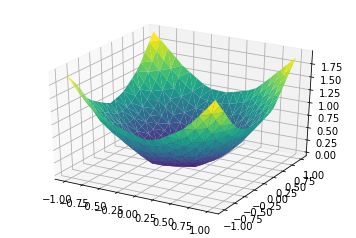

actual:


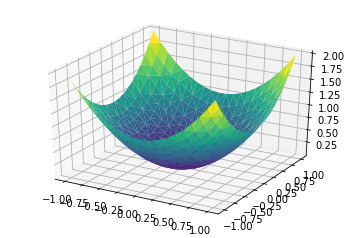

In [16]:

# Get the data (csv file is hosted on the web)
 
df = df_predict
 
# Make the plot
print('predicted:')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['x_1'], df['x_2'], df['y_predicted'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

print('actual:')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['x_1'], df['x_2'], df['y'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

 

They look the same.